# Clasificación. Parte II - Clasificación Multiclase

Seguimos con un sistema de aprendizaje **supervisado** de **clasificación**.

Mientras que un clasificador binario distingue dos clases, un **clasificador multiclase** o **clasificador multinomial** puede distinguir más de dos clases.

Continuamos trabajando con el dataset **MNIST** (Modified National Institute of Standards and Technology).

En este caso, nuestro objetivo es crear un modelo que sea capaz de decir a qué dígito se corresponde una imagen determinada.

## Importación de paquetes

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Carga de datos

In [2]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml("mnist_784", version=1)

Hay varias estrategias posibles para clasificar los dígitos del 0 al 9:
- <u>Crear un clasificador para cada dígito</u>, aplicarlos todos y quedarnos con el resultado que nos interesa. Este método se llama **OvR** (*One versus the Rest*) o también se puede llamar **OvA** (*One versus All*). Por ejemplo, si el dígito es un 7, el clasificador 0/no 0 dirá que no es un 0, el clasificador 1/no 1 dirá que no es un 1,... y el de 7/no 7 **SÍ** dirá que es un 7.

- <u>Crear un clasificador para cada par de dígitos</u>, uno que distinga entre 0 y 1, otro entre 0 y 2, ..., otro entre 1 y 2, ..., otro entre 2 y 3, ... Si hay $N$ clases, necesitamos $\frac{N \times (N - 1)}{2}$ clasificadores. En el caso que nos ocupa, tendríamos que crear 45 clasificadores. A cada imagen habría que pasarle los 45 clasificadores y puntuar cada resultado. Escogeríamos la clase que mejor se haya comportado, igual que una liga de fútbol, en la que se enfrenta cada equipo con todos los demás, gana el que más puntos tiene. Esta técnica se llama **OvO** (*One versus One*). Por ejemplo, si el dígito es un 8, al aplicar el clasificador 0/8, saldrá el 8 y se le dará un punto, al aplicar el clasificador 1/8, saldrá el 8 y se le dará otro punto, etc. Al final, el número con mas puntos será el 8.

- <u>Crear un clasificador multiclase (nativo)</u>, hay algoritmos, como por ejemplo el *k-Nearest Neighbours*, que trabajan bien detectando de forma nativa varias clases diferentes.

## Extracción de la matriz de datos y el vector correspondiente al atributo objetivo

In [3]:
X = mnist["data"]
y = mnist["target"]

y = y.astype(np.uint8)

## Creación del conjunto de datos de entrenamiento y de los datos de prueba

In [4]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## Extracción de algunos números de prueba

<function matplotlib.pyplot.show(close=None, block=None)>

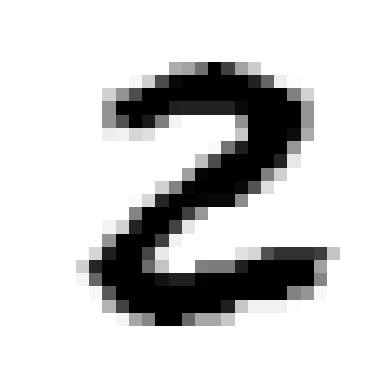

In [5]:
example_digit1 = X.loc[25].to_numpy()
example_digit1_image = example_digit1.reshape(28, 28)
plt.imshow(example_digit1_image, cmap="binary")
plt.axis("off")
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

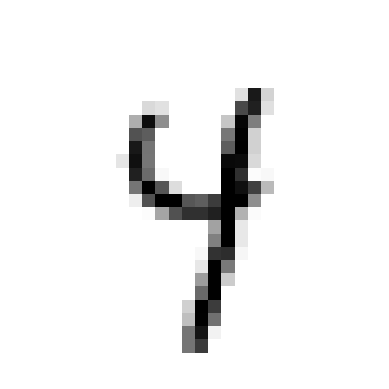

In [6]:
example_digit2 = X.loc[26].to_numpy()
example_digit2_image = example_digit2.reshape(28, 28)
plt.imshow(example_digit2_image, cmap="binary")
plt.axis("off")
plt.show

## Creación de un clasificador multiclase a partir de la técnica **OvO**

Vamos a usar el algoritmo *SVM* (Support Vector Machine) que es intrínsecamente un clasificador binario.

Scikit Learn es capaz de detectar que queremos hacer una clasificación multiclase y "por debajo" usa la técnica **OvO**, es decir, crea 45 clasificadores.

In [7]:
from sklearn.svm import SVC # SupportVectorClassification

mnist_model = SVC()
mnist_model.fit(X_train, y_train)

SVC()

In [8]:
# Probamos con los dígitos de ejemplo anteriores

mnist_model.predict([example_digit1, example_digit2])

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


array([2, 4], dtype=uint8)

In [9]:
# Muestra las clases

mnist_model.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [10]:
# Puntuación de cada una de las clases para cada imagen
# La clase correspondiente al 2, por ejemplo, debería de tener la máxima puntuación

mnist_model.decision_function([example_digit1])

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


array([[ 4.92505076,  3.74597077,  9.31442812,  8.30989605, -0.3123735 ,
         5.78209525,  2.71797624,  0.69243018,  7.3117808 ,  1.71052032]])

In [11]:
# Puntuación de cada una de las clases para cada imagen
# La clase correspondiente al 4, por ejemplo, debería de tener la máxima puntuación

mnist_model.decision_function([example_digit2])

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


array([[-0.30561611,  2.71904625,  2.72182152,  6.1750562 ,  9.31070254,
         2.78903166,  0.70489991,  7.28077821,  5.12715056,  8.30325366]])

Se clasifican correctamente las imágenes y vemos que el 2 se parece bastante al 3 y al 8 y el 4 se parece al 9 (por las puntuaciones obtenidas).

## Rendimiento del modelo SVC

### Aciertos y fallos

Usamos los datos de prueba para hacer las predicciones y comprobamos si son correctas.

In [12]:
y_test_pred = mnist_model.predict(X_test)

success = (y_test == y_test_pred)

aciertos = success[success == True].size
fallos = success[success == False].size

print("Aciertos:", aciertos)
print("Fallos:", fallos)
print("Precision:", aciertos / (aciertos + fallos) * 100, "%")

Aciertos: 9792
Fallos: 208
Precision: 97.92 %


### Validación cruzada (cross validation)

En la validación cruzada, se dividen los datos de entrenamiento en varios grupos.

In [13]:
from sklearn.model_selection import cross_val_score

cross_val_score(mnist_model, X_train, y_train, cv=3)

array([0.977 , 0.9738, 0.9739])

### Matriz de confusión

Cada columna de la matriz representa el número de predicciones de cada clase, mientras que cada fila representa a las instancias de la clase real.

In [14]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_test_pred)
print(cm)

[[ 973    0    1    0    0    2    1    1    2    0]
 [   0 1126    3    1    0    1    1    1    2    0]
 [   6    1 1006    2    1    0    2    7    6    1]
 [   0    0    2  995    0    2    0    5    5    1]
 [   0    0    5    0  961    0    3    0    2   11]
 [   2    0    0    9    0  871    4    1    4    1]
 [   6    2    0    0    2    3  944    0    1    0]
 [   0    6   11    1    1    0    0  996    2   11]
 [   3    0    2    6    3    2    2    3  950    3]
 [   3    4    1    7   10    2    1    7    4  970]]


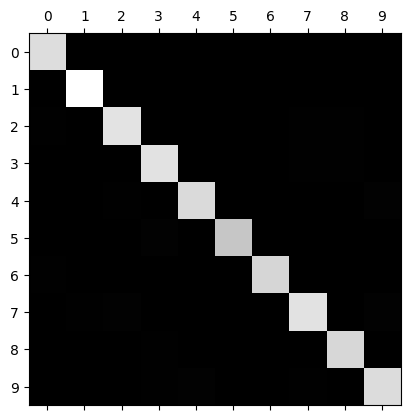

In [15]:
# Representación gráfica de la matriz de confusión

plt.matshow(cm, cmap=plt.cm.gray)
plt.xticks(np.arange(10))
plt.yticks(np.arange(10))
plt.show()

La matriz de confusión muestra que el modelo se comporta correctamente.

### Creación de un clasificador multiclase con el algoritmo **K-Nearest Neightbours**

Vamos a usar el algoritmo K-Nearest Neightbours **K-Nearest Neightbours** (K-vecinos más cercanos) que es, de forma nativa, un clasificador multiclase.

In [16]:
from sklearn.neighbors import KNeighborsClassifier

mnist_model_knn = KNeighborsClassifier()
mnist_model_knn.fit(X_train, y_train)

KNeighborsClassifier()

In [17]:
mnist_model_knn.predict([example_digit1, example_digit2])

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


array([2, 4], dtype=uint8)

El modelo predice bien los dos casos.

## Rendimiento del modelo KNN

In [18]:
y_test_pred = mnist_model_knn.predict(X_test)

success = (y_test == y_test_pred)

aciertos = success[success == True].size
fallos = success[success == False].size

print("Aciertos:", aciertos)
print("Fallos:", fallos)
print("Precision:", aciertos / (aciertos + fallos) * 100, "%")

Aciertos: 9688
Fallos: 312
Precision: 96.88 %


Un $96.88$% de aciertos con un modelo creado mucho más rápido.

In [20]:
cm = confusion_matrix(y_test, y_test_pred)
print(cm)

[[ 974    1    1    0    0    1    2    1    0    0]
 [   0 1133    2    0    0    0    0    0    0    0]
 [  11    8  991    2    1    0    1   15    3    0]
 [   0    3    3  976    1   13    1    6    3    4]
 [   3    7    0    0  944    0    4    2    1   21]
 [   5    0    0   12    2  862    4    1    2    4]
 [   5    3    0    0    3    2  945    0    0    0]
 [   0   22    4    0    3    0    0  988    0   11]
 [   8    3    5   13    6   12    5    5  913    4]
 [   5    7    3    9    7    3    1   10    2  962]]


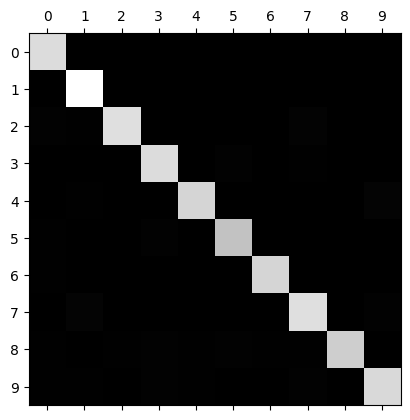

In [21]:
# Representación gráfica de la matriz de confusión

plt.matshow(cm, cmap=plt.cm.gray)
plt.xticks(np.arange(10))
plt.yticks(np.arange(10))
plt.show()